In [1]:
%matplotlib inline

import geopandas as gpd

from tile_unit import TileUnit
from tile_map import Tiling

In [2]:
ak = gpd.read_file("../data/imd-auckland-2018.gpkg")

# Cairo tiles [3<sup>2</sup>.4.3.4]
The one true tiling. Provides 4 directionally distinguishable elements... and also can be read two different ways (intersecting hexagons runninng in two orthogonal directions).

<AxesSubplot:>

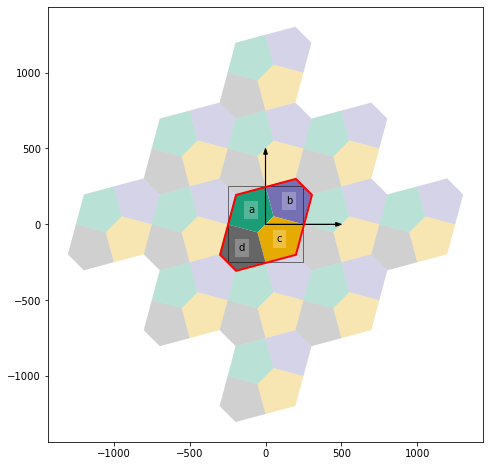

In [3]:
tile_unit = TileUnit(tiling_type = "laves", code = "3.3.4.3.4",
                     spacing = 500, crs = ak.crs)
tile_unit.plot(r = 2, show_vectors = True)

In [4]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018", tile_margin = 12.5)

In [5]:
t = tiling.get_tiled_map(rotation = 45, prioritise_tiles = True)

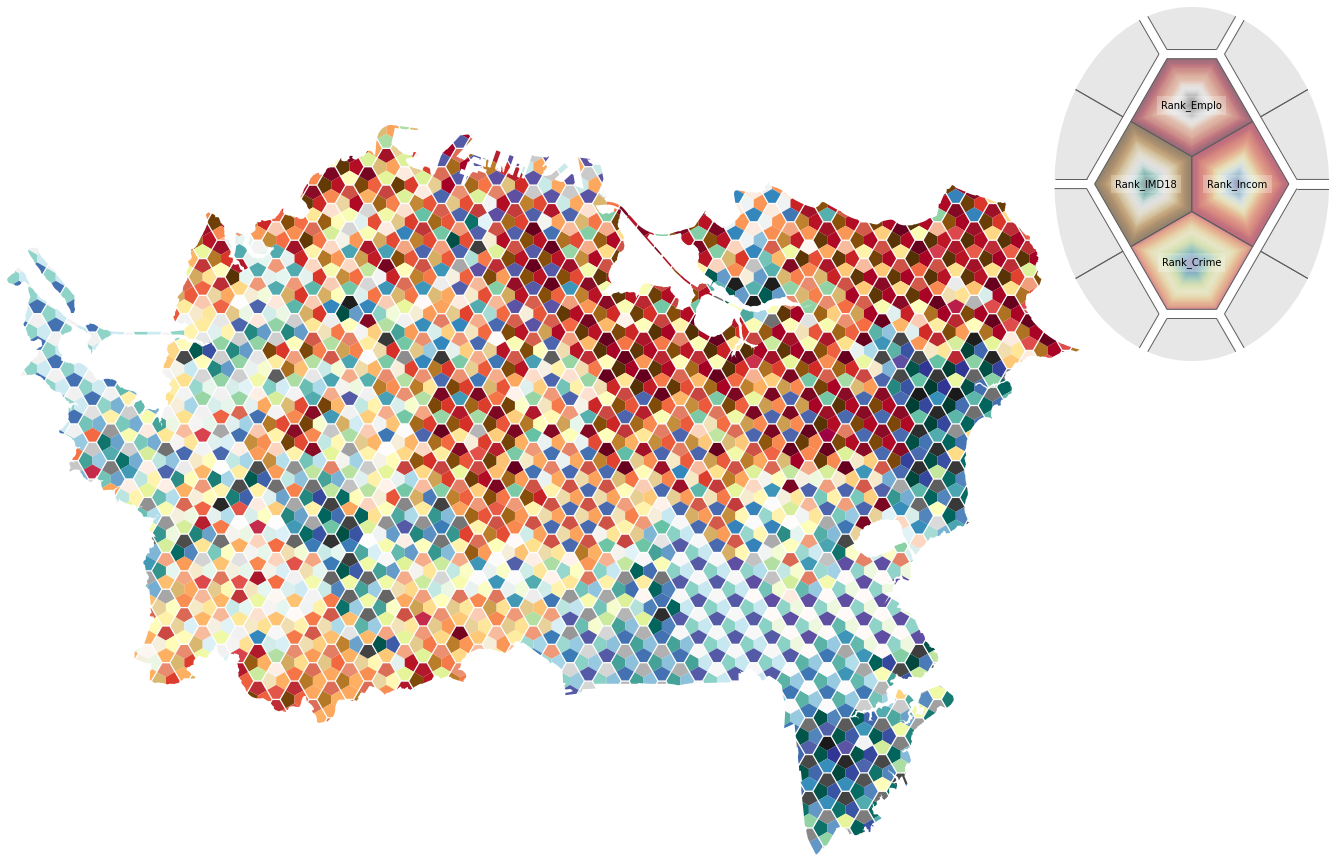

In [6]:
t.variables = dict(zip(list("abcd"), 
                         [x for x in ak if "Rank" in x]))
t.colourmaps = dict(zip(t.variables.values(), 
                          ("BrBG", "RdGy", "RdYlBu", "Spectral", 
                           "PiYG", "PRGn", "PuOr", "viridis")))

fig = t.render(use_ellipse = True, legend_dx = -0.05, legend_dy = -0.05)

## An alternative perspective
The elements of any given tiling can be rearranged with respect to the base tile, and if the `regularised_tile` is then remade from the repositioned elements, different effects can be achieved by insetting to emphasize different repeating units in the pattern.

In this case, we move the lower two elements _c_ and _d_ up half a tile, and the upper two _a_ and _b_ down half a tile we can form a cross-like grouping of the tiles instead of the hexagonal arrangement. The retiled map is quite different in appearance, although it contains the same data.

<AxesSubplot:>

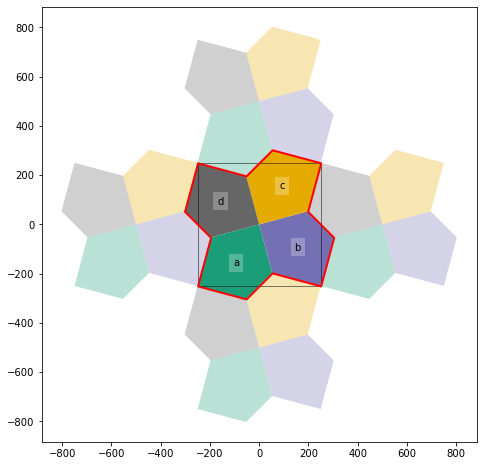

In [7]:
from shapely.affinity import translate

v = tile_unit.get_vectors()
v = [v[3], v[3], v[1], v[1]]  # these are the up and down vectors
tile_unit.elements.geometry = gpd.GeoSeries(
    [translate(g, xy[0] / 2, xy[1] / 2) 
     for g, xy in zip(tile_unit.elements.geometry, v)])
tile_unit.make_regularised_tile_from_elements()
tile_unit.plot(r = 1)

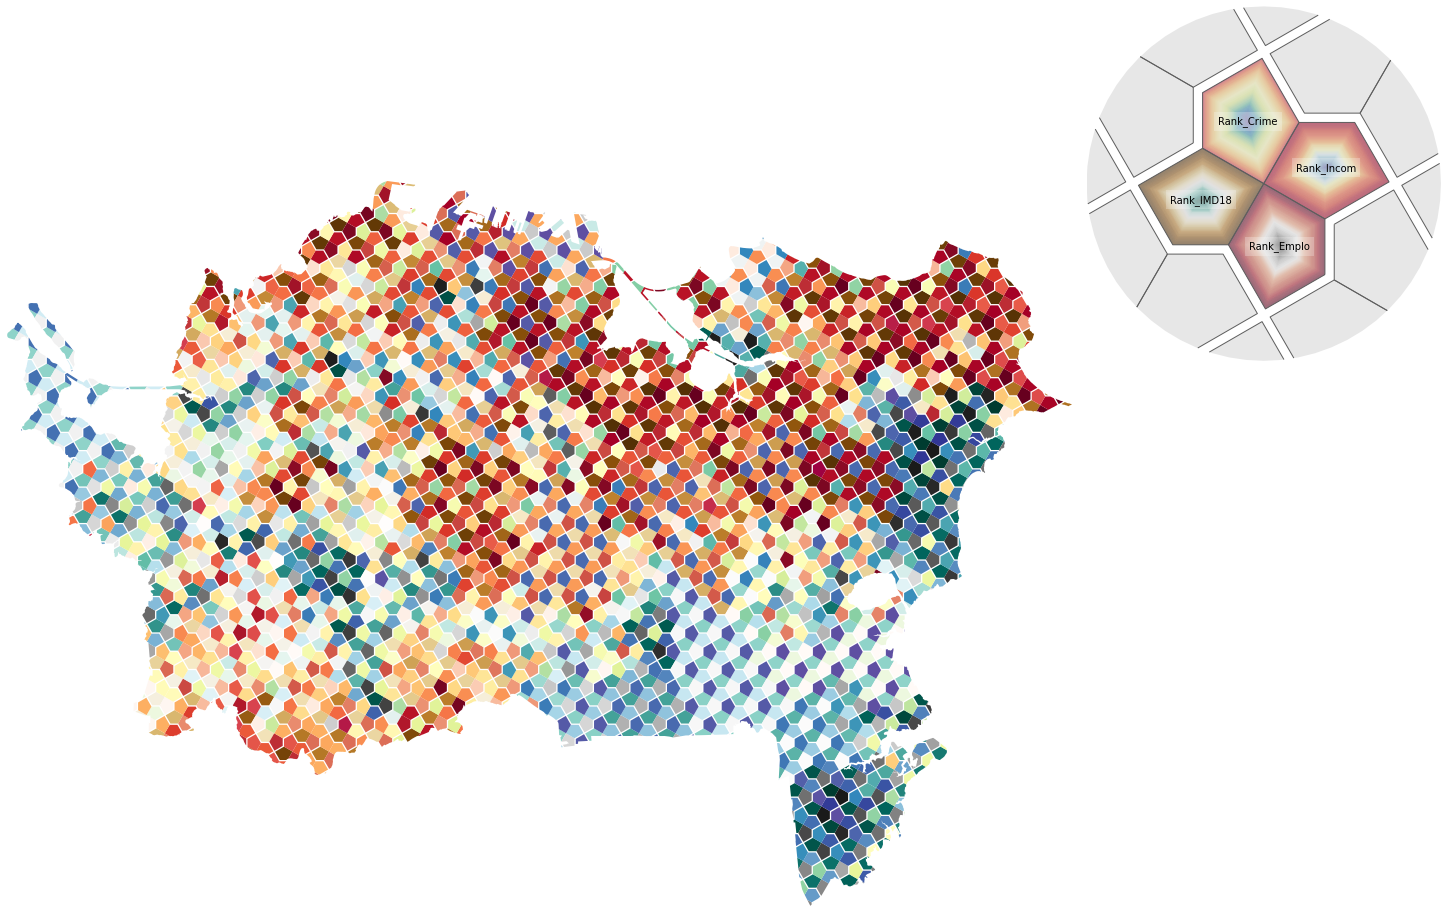

In [8]:
tiling = Tiling(tile_unit, ak, id_var = "DZ2018", tile_margin = 12.5)
t = tiling.get_tiled_map(rotation = -45, prioritise_tiles = True)

t.variables = dict(zip(list("abcd"), 
                         [x for x in ak if "Rank" in x]))
t.colourmaps = dict(zip(t.variables.values(), 
                          ("BrBG", "RdGy", "RdYlBu", "Spectral", 
                           "PiYG", "PRGn", "PuOr", "viridis")))

fig = t.render(use_ellipse = True, legend_dy = -0.05)